# Relating protein structure and post-translational modifications

The goal is to characterize whether various types of post-translational modifications (PTMs) occur more frequently in intrinsically disordered regions (IDRs) of proteins (1). The target of inference is the odds ratio associating being in an IDR and having a PTM.
This notebook shows how to do inference on the odds ratio via PPI by using structures predicted by AlphaFold (2) to predict IDRs. IDRs are predicted from structures following the strategy of Bludau et al. (3).

1. L. M. Iakoucheva, P. Radivojac, C. J. Brown, T. R. O’Connor, J. G. Sikes, Z. Obradovic, A. K. Dunker, The importance of intrinsic disorder for protein phosphorylation. Nucleic Acids Res. 32, 1037–1049 (2004).
2. J. Jumper, R. Evans, A. Pritzel, T. Green, M. Figurnov, O. Ronneberger, K. Tunyasuvunakool, R. Bates, A. Žídek, A. Potapenko, A. Bridgland, C. Meyer, S. A. A. Kohl, A. J. Ballard, A. Cowie, B. Romera-Paredes, S. Nikolov, R. Jain, J. Adler, T. Back, S. Petersen, D. Reiman, E. Clancy, M. Zielinski, M. Steinegger, M. Pacholska, T. Berghammer, S. Bodenstein, D. Silver, O. Vinyals, A. W. Senior, K. Kavukcuoglu, P. Kohli, D. Hassabis, Highly accurate protein structure prediction with AlphaFold. Nature 596(7873), 583–589 (2021). 
3. I. Bludau, S. Willems, W-F. Zeng, M. T. Strauss, F. M. Hansen, M. C. Tanzer, O. Karayel, B. A. Schulman, M. Mann, The structural context of posttranslational modifications at a proteome-wide scale. PLoS Biology 20(5), e3001636 (2022).

### Import necessary packages

In [1]:
import numpy as np
from ppi_py.datasets import load_dataset
from ppi_py import analyze_dataset, plot_cpp
import pandas as pd
import os

### Import the AlphaFold data set

Load the data. The data set contains true indicators of disorder (```Y```), predicted indicators of disorder (```Yhat```), and indicators of a PTM (```phosphorylated```, ```ubiquitinated```, or ```acetylated```). Predictions of disorder are made based on AlphaFold predictions of structure.

In [2]:
dataset_name = "alphafold"
data = load_dataset('./data/', dataset_name)
Y_total = data["Y"]
Yhat_total = data["Yhat"]
Z = data["phosphorylated"].astype(
    bool
)  # Can choose from "phosphorylated", "ubiquitinated", or "acetylated"
# method_name = "ppi_mean_ci"

dataset_dist = 'IID'
# dataset_dist = 'Non-IID'

alpha = 0.1

method = 'mean'

Y0_total, Y1_total = Y_total[~Z], Y_total[Z]
Yhat0_total, Yhat1_total = Yhat_total[~Z], Yhat_total[Z]

### Problem setup

Specify the error level (```alpha```), range of values for the labeled data set size (```ns```), and number of trials (```num_trials```).

Compute the ground-truth value of the estimand.

In [3]:
# num_ratio = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
num_ratio = [1, 1, 1, 1, 1]  # 数据量分布平衡
# num_ratio = [1,2,3,3,1]  # 数据量分布不平衡

# 计算标注真实值、各节点上、组合数据后和FL后的平均值cpp
true_theta0, cpp_intervals0, ppi_ci_combined0, mean_cpp0 = analyze_dataset(alpha, None, Y0_total, Yhat0_total, dataset_dist,
                                                                            num_ratio, method, grid=None)

true_theta1, cpp_intervals1, ppi_ci_combined1, mean_cpp1 = analyze_dataset(alpha, None, Y1_total, Yhat1_total, dataset_dist,
                                                                            num_ratio, method, grid=None)

# True odds ratio
true_theta = (true_theta1 / (1 - true_theta1)) / (true_theta0 / (1 - true_theta0))

分组： 1
带标签的样本量： 50
不带标签的样本量： 907
分组： 2
带标签的样本量： 50
不带标签的样本量： 907
分组： 3
带标签的样本量： 50
不带标签的样本量： 907
分组： 4
带标签的样本量： 50
不带标签的样本量： 907
分组： 5
带标签的样本量： 50
不带标签的样本量： 907
imputed var: [1.01273933e-05]
rectifier var [0.00013614]
带标签的样本量： 250
不带标签的样本量： 4535

最终结果：
真实 theta: 0.11912225705329153
CPP intervals: [array([0.04330896, 0.12766907]), array([0.06902553, 0.17733023]), array([0.08495339, 0.19798915]), array([0.05981002, 0.09721689]), array([0.07306652, 0.15281496])]
组合数据的置信区间: [0.08892823 0.12864615]
联邦聚合后的置信区间: [0.08842531 0.12821163]
Updated CSV file 'parameters.csv' successfully.
分组： 1
带标签的样本量： 63
不带标签的样本量： 1141
分组： 2
带标签的样本量： 63
不带标签的样本量： 1141
分组： 3
带标签的样本量： 63
不带标签的样本量： 1140
分组： 4
带标签的样本量： 63
不带标签的样本量： 1140
分组： 5
带标签的样本量： 63
不带标签的样本量： 1140
imputed var: [1.77480383e-05]
rectifier var [0.00016737]
带标签的样本量： 315
不带标签的样本量： 5702

最终结果：
真实 theta: 0.22369951803224197
CPP intervals: [array([0.16027878, 0.25706231]), array([0.17156039, 0.25694364]), array([0.21424047, 0.33654215]), array([0.1811788

### Construct intervals

Form confidence intervals for all methods and problem parameters. A dataframe with the following columns is formed:
1. ```method``` (one of ```PPI```, ```Classical```, and ```Imputation```)
2. ```n``` (labeled data set size, takes values in ```ns```)
3. ```lower``` (lower endpoint of the confidence interval)
4. ```upper``` (upper endpoint of the confidence interval)
5. ```trial``` (index of trial, goes from ```0``` to ```num_trials-1```)

In [4]:
def odds_ratio_ci(mu0_ci, mu1_ci):
    # First construct CI of mu0/(1-mu0) and mu1/(1-mu1)
    r0 = [mu0_ci[0] / (1 - mu0_ci[0]), mu0_ci[1] / (1 - mu0_ci[1])]
    r1 = [mu1_ci[0] / (1 - mu1_ci[0]), mu1_ci[1] / (1 - mu1_ci[1])]
    return r1[0] / r0[1], r1[1] / r0[0]

In [5]:
cpp_intervals = []
for i in range(len(cpp_intervals0)):
    tmp = odds_ratio_ci(cpp_intervals0[i], cpp_intervals1[i])
    print(tmp)
    cpp_intervals.append(np.array(tmp))

ppi_ci_combined = odds_ratio_ci(ppi_ci_combined0, ppi_ci_combined1)

mean_cpp = odds_ratio_ci(mean_cpp0, mean_cpp1)

(1.3041768022138955, 7.643283514753679)
(0.9607246860634647, 4.663845598427824)
(1.104461838159551, 5.463722267187888)
(2.0547549140650405, 5.875516804923255)
(1.000148680499427, 4.307932046013147)


### Plot results

Plot:
1. Five randomly chosen intervals from the dataframe for PPI and the classical method, and the imputed interval;
2. The average interval width for PPI and the classical method, together with a scatterplot of the widths from the five random draws.

true theta 2.1308747140812856
FL (1.734430010443027, 3.399702468804126)
组合数据 (1.7506718307894225, 3.4150320402680463)
Client [array([1.3041768 , 7.64328351]), array([0.96072469, 4.6638456 ]), array([1.10446184, 5.46372227]), array([2.05475491, 5.8755168 ]), array([1.00014868, 4.30793205])]


meta NOT subset; don't know how to subset; dropped


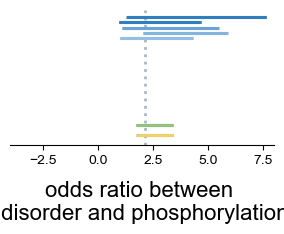

In [6]:
print("true theta", true_theta)
print("FL",mean_cpp)
print("组合数据", ppi_ci_combined)
print('Client', cpp_intervals)
# # 文件名
# filename = 'parameters.csv'
# 
# # 新的数组数据
# new_data = {
#     'centralized_lower': [ppi_ci_combined[0]],
#     'centralized_upper': [ppi_ci_combined[1]],
#     'fl_lower': [mean_cpp[0]],
#     'fl_upper': [mean_cpp[1]]
# }
# 
# # 检查参数文件是否存在
# if os.path.exists(filename):
#     # 如果文件存在，读取现有数据
#     df = pd.read_csv(filename)
# else:
#     # 如果文件不存在，创建一个空的 DataFrame
#     df = pd.DataFrame(columns=['centralized_lower', 'centralized_upper', 'fl_lower', 'fl_upper'])
# 
# # 将新数据添加到 DataFrame
# new_df = pd.DataFrame(new_data)
# df = pd.concat([df, new_df], ignore_index=True)
# 
# # 保存更新后的数据到CSV文件
# df.to_csv(filename, index=False)
# 
# print(f"Updated CSV file '{filename}' successfully.")

file_name = dataset_dist + '-' + dataset_name + '.pdf'
xlim = [-4, 8]
ylim = [0, 1.0]
title = "odds ratio between \n disorder and phosphorylation"
plot_cpp(true_theta, cpp_intervals, ppi_ci_combined, mean_cpp, file_name, xlim, ylim, title)